In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

%matplotlib inline

In [3]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [4]:
print(s)
iall, = np.where( (s.r() < s.galrad) & (s.r() > 0.) )

mask = iall
(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, mask)
(R_kpc, phi, z_kpc), (vR_kms, vphi, vz_kms) = get_cylindrical_vectors(s, sf, mask)


(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, mask)

rho, Rbin, z, vol = fitting_dens(s.mass[mask][np.abs(z > -50.) & np.abs(z <50.)], R[np.abs(z > -50.) & np.abs(z <50.)], z[np.abs(z > -50.) & np.abs(z <50.)])
#rho, R, z, vol = fitting_dens(s)
print(R)
print(z)

4
0.000591963 24.0853 -23.9838 24.0577
[ 0.44943228  0.46022999  0.44905335 ...,  7.49414206  0.88731605
  0.07221486]
[ -2.39837666e+01  -2.29837666e+01  -2.19837666e+01  -2.09837666e+01
  -1.99837666e+01  -1.89837666e+01  -1.79837666e+01  -1.69837666e+01
  -1.59837666e+01  -1.49837666e+01  -1.39837666e+01  -1.29837666e+01
  -1.19837666e+01  -1.09837666e+01  -9.98376656e+00  -8.98376656e+00
  -7.98376656e+00  -6.98376656e+00  -5.98376656e+00  -4.98376656e+00
  -3.98376656e+00  -2.98376656e+00  -1.98376656e+00  -9.83766556e-01
   1.62334442e-02   1.01623344e+00   2.01623344e+00   3.01623344e+00
   4.01623344e+00   5.01623344e+00   6.01623344e+00   7.01623344e+00
   8.01623344e+00   9.01623344e+00   1.00162334e+01   1.10162334e+01
   1.20162334e+01   1.30162334e+01   1.40162334e+01   1.50162334e+01
   1.60162334e+01   1.70162334e+01   1.80162334e+01   1.90162334e+01
   2.00162334e+01   2.10162334e+01   2.20162334e+01   2.30162334e+01
   2.40162334e+01]


In [10]:
### finde nen Weg um das ganze von klein r abhängig zu machen 
### finde sinnvolle Standartwerte für Initialisierungs Parameter
### eventuell nur dens ODER pot ausgeben, hängt von Fit funktion ab 
### ravel works in the way I want?


#def galpy_fitting(r, R, z, r0, v0, a_mp = 0.5, b_mp = 0.0375, n_mp = 0.6, a_nfw = 4.5, n_nfw = 0.35, \
#                  a_he = 0.6 / 8., n_he = 0.05, hr_de = 0.3333333333333333, hz_de = 0.0625, \
#                  dens_fit = True, pot_fit = False):
 
def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, n_he,\
                  r = None, R = None, z = None, r0 = 8., v0 = 220., dens_fit = True, pot_fit = False):    
    #hr_de = None, hz_de = None,
    
    mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
    nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
    hep = HEpot(a = a_he, normalize = n_he, ro = r0, vo = v0)
    #de = DEpot(hr = hr_de, hz = hz_de, normalize = 1. - (n_mp + n_nfw + n_he), ro = r0, vo = v0)
    
    pot = [mp, nfwp, hep]
    densi = np.zeros([len(R), len(z)])
    pot_mod = np.zeros([len(R), len(z)])
    if dens_fit == True:
        for ii, Rii in enumerate(R):
            for jj, zjj in enumerate(z):
                densi[ii, jj] = evaluateDensities(pot, Rii, zjj)
    if pot_fit == True:
        for ii, Rii in enumerate(R):
            for jj, zjj in enumerate(z):
                pot_mod[ii, jj] = evaluatePotentials(pot, Rii, zjj)
            
    #densi = np.ravel(densi)
    pot_mod = np.ravel(pot_mod)
    
    if (dens_fit == True) * (pot_fit == False):
        return densi
    elif (dens_fit == False) * (pot_fit == True):
        return pot_mod
    else:
        print('Check that fitting algorithm can handle to return density and potential.')
        return densi, pot_mod

In [11]:
# FITTING

# scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, 
# bounds=None, constraints=(), tol=None, callback=None, options=None)[source]

#fun = sqrt(for each i in (true_i - model_i)**2) called RMS
#opt.minimize(fun, x0 = 0) 

#def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, n_he, hr_de, hz_de,\
#                  r = None, R = None, z = None, r0 = 8., v0 = 220., dens_fit = True, pot_fit = False):    


def RMS(x, r, R, z, N, rho, r0, v0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, n_he = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    ydata = rho
    ymodel = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, n_he, r, R, z, r0, v0)
    RMS = np.sqrt(1./N*np.abs(np.sum(ydata - ymodel)))
    return RMS


a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.25  
a_nfw = 4.5 
n_nfw = 0.25 
a_he = 0.6 / 8. 
n_he = 0.25 
hr_de = 0.3 
hz_de = 0.0625

x0 = (a_mp, b_mp, n_mp,  a_nfw , n_nfw , a_he, n_he)

bounds = ((0., None), (0., None), (0., None), (0., None), (0., None), (0., None), (0., None))
r, R, z, rho = R, Rbin, z, rho
#rho, R, z, vol = fitting_dens(s)

r0, v0 = 8., 220.
N = len(r)
x = opt.minimize(RMS, x0 = x0, args= (r, R, z, N, rho, r0, v0), bounds = bounds)

### CURVE_FIT might give problems since there are some bool args that do not need a fit. 
### Also having R and z as input values instead of just r might cause problems. 
### Think of that or first try minimize with RMS method

# scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, 
# check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

#xdata = s.r()
# check in which direction ravel goes over the arrays to calculate xdata in the irght way
'''
rho, rho_arr_real, rho_arr_mean, Rbins, zbins, volbins = dens(s)
ydata = np.ravel(rho)
xdata = np.zeros(len(Rbins), len(zbins))
for ii, Rii in enumerate(Rbins):
    for jj, zjj in enumerate(zbins):
        xdata[ii,jj] = np.sqrt(Rii ** 2 + zjj **2)
            
popt, pcov = opt.curve_fit(galpy_fitting, np.ravel(xdata), ydata, sigma = np.ravel(volbins), absolute_sigma = True)
'''

'\nrho, rho_arr_real, rho_arr_mean, Rbins, zbins, volbins = dens(s)\nydata = np.ravel(rho)\nxdata = np.zeros(len(Rbins), len(zbins))\nfor ii, Rii in enumerate(Rbins):\n    for jj, zjj in enumerate(zbins):\n        xdata[ii,jj] = np.sqrt(Rii ** 2 + zjj **2)\n            \npopt, pcov = opt.curve_fit(galpy_fitting, np.ravel(xdata), ydata, sigma = np.ravel(volbins), absolute_sigma = True)\n'

In [12]:
x

      fun: 0.00020149495050720274
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([   9.28184972,   32.94612611,  -40.8248978 ,    0.99761503,
       -266.54995732,   51.0675611 , -615.55257549])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 416
      nit: 6
   status: 0
  success: True
        x: array([ 0.52801226,  0.22150982,  0.19957623,  4.500342  ,  0.18998707,
        1.09749376,  0.10448814])

In [14]:
a_mp, b_mp, n_mp = x.x[0], x.x[1], x.x[2]
a_nfw , n_nfw = x.x[3]  , x.x[4]
a_he, n_he = x.x[5],  x.x[6]

In [15]:
mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
hep = HEpot(a = a_he, normalize = n_he, ro = r0, vo = v0)
    
pot = [mp,nfwp,hep]


In [17]:
dens_final = galpy_fitting(a_mp, b_mp, n_mp, a_nfw , n_nfw, a_he, n_he, R= R, z= z)

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

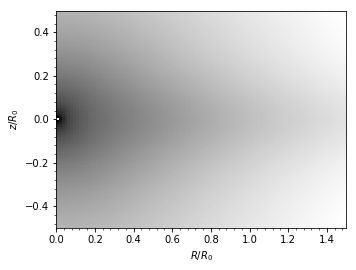

In [27]:
plotDensities(pot,nrs=101,nzs=101, log = True)

In [26]:
rho

array([[  7.19996005e-05,   9.98030600e-06,   1.20688189e-04, ...,
          3.99212240e-05,   3.11375324e-05,   1.99606120e-05],
       [  7.47447322e-05,   4.66115145e-05,   7.39282196e-05, ...,
          1.01654181e-04,   6.65878602e-05,   3.32939340e-06],
       [  4.20075264e-05,   9.65184606e-05,   8.03436579e-05, ...,
          8.33643972e-05,   6.53320614e-05,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [28]:
import calcGrid

In [30]:
calcGrid.calcRadialProfile()

TypeError: calcRadialProfile( pos, data, mode, nshells, dr, centerx, centery, centerz )() takes at least 2 arguments (0 given)

In [ ]:
# find circular velocity in outskirts
# from The GigaGalaxy Project (analysis tool) / galaxy / plot_rotcurve_multi.py
s = gadget_readsnap( snap, snappath=dd+'/output/', hdf5=True, loadonlytype=[0, 1, 4, 5], loadonly=attrs )
sf = load_subfind( snap, dir=dd+'/output/', hdf5=True, loadonly=['fpos', 'frc2'] )
s.center = sf.data['fpos'][subhalo,:]

pos = s.data['pos'].astype('float64')
mass = s.data['mass'].astype('float64')

nshells = 100
radius = 0.04
dr = radius / nshells

na = s.nparticlesall
end = na.copy()
end[1:] += end[:-1]
start = np.zeros(len(na), dtype='int32')
start[1:] = end[:-1]

        shmass = pylab.zeros( (nshells, 6) )
        shvel = pylab.zeros( (nshells, 6) )
        vtot = pylab.zeros(nshells)
for i in range( 6 ):
    rp = calcGrid.calcRadialProfile( s.pos[start[i]:end[i],:].astype('float64'), s.data['mass'][start[i]:end[i]].astype('float64'), 0, nshells, dr, s.center[0], s.center[1], s.center[2] )

    radius = rp[1,:]
    shmass[:,i] = rp[0,:]
        for j in range( 1, nshells ):
            shmass[j,i] += shmass[j-1,i]
    shvel[:,i] = np.sqrt( 43.0071 * shmass[:,i] / (radius) )
    vtot[:] += (shvel[:,i]**2)

